In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression

In [15]:
df = pd.read_csv("./creditcard.csv")

In [16]:
print(df.shape)  # 看有幾列幾欄
print(df.columns)  # 看有哪些欄位
# print(df.head())          # 頭五筆觀察欄位意義
# print(df.describe())      # 各欄統計數值
print(df["Class"].value_counts())  # 詐欺比例

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Class
0    284315
1       492
Name: count, dtype: int64


In [17]:
df.isnull().sum()  # 檢查缺失值
print(df.duplicated().sum())  # 檢查重複資料
df = df.drop_duplicates()  # 移除重複值
print(df.duplicated().sum())  # 檢查重複資料

1081
0


In [18]:
scaler = StandardScaler()
df["normAmount"] = scaler.fit_transform(df[["Amount"]])
df["normTime"] = scaler.fit_transform(df[["Time"]])

# 可移除原始欄位（避免重複）
df.drop(["Amount", "Time"], axis=1, inplace=True)

In [19]:
fraud = df[df["Class"] == 1]
non_fraud = df[df["Class"] == 0].sample(n=len(fraud), random_state=42)
print(len(fraud))
balanced_df = pd.concat([fraud, non_fraud])
# print(balanced_df)
# 打亂順序
balanced_df = balanced_df.sample(frac=1, random_state=42)
# print(balanced_df)

473


In [20]:
X = balanced_df.drop("Class", axis=1)
y = balanced_df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# print(X.info())
print(y)
# print(balanced_df.info())
print(balanced_df.columns.get_loc("Class"))  # 查看Class在第幾欄

154697    1
8842      1
91708     0
233258    1
17317     1
         ..
41395     1
144108    1
36725     0
249239    1
33276     1
Name: Class, Length: 946, dtype: int64
28


In [21]:
model = LogisticRegression()
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


[[94  1]
 [ 6 89]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        95
           1       0.99      0.94      0.96        95

    accuracy                           0.96       190
   macro avg       0.96      0.96      0.96       190
weighted avg       0.96      0.96      0.96       190

ROC AUC: 0.9836011080332411


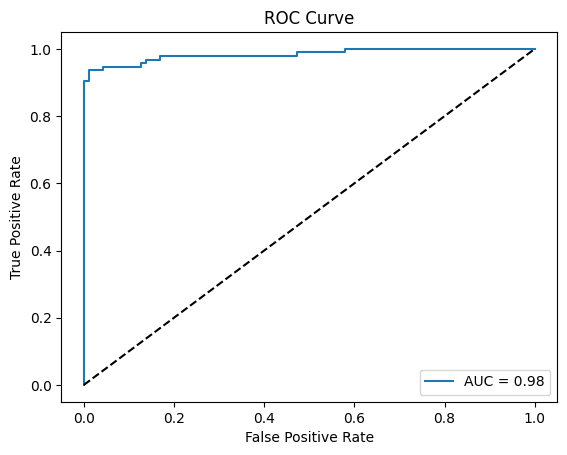

In [22]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # 機率值

# 混淆矩陣
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# AUC
auc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", auc)

# 繪製 ROC 曲線
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [23]:
print(type(model))

<class 'sklearn.linear_model._logistic.LogisticRegression'>


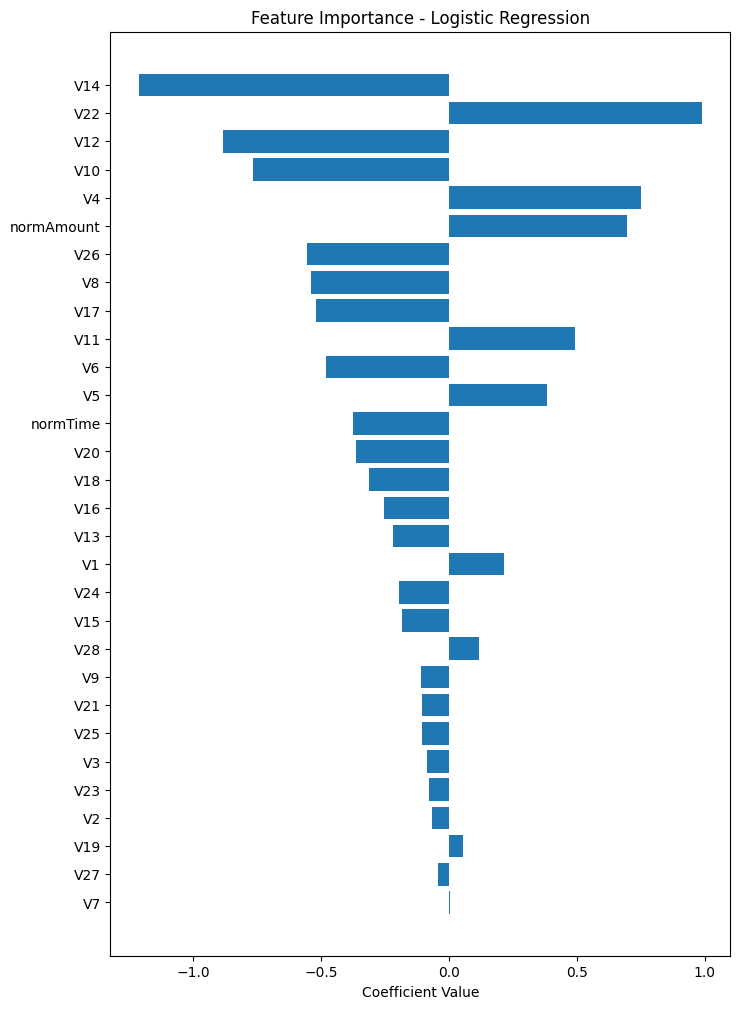

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 假設 model 是已訓練的 LogisticRegression
# X 是訓練用特徵 DataFrame

coef = model.coef_[0]
features = X.columns

# 依係數絕對值排序
indices = np.argsort(np.abs(coef))

plt.figure(figsize=(8, 12))
plt.barh(features[indices], coef[indices])
plt.xlabel("Coefficient Value")
plt.title("Feature Importance - Logistic Regression")
plt.show()

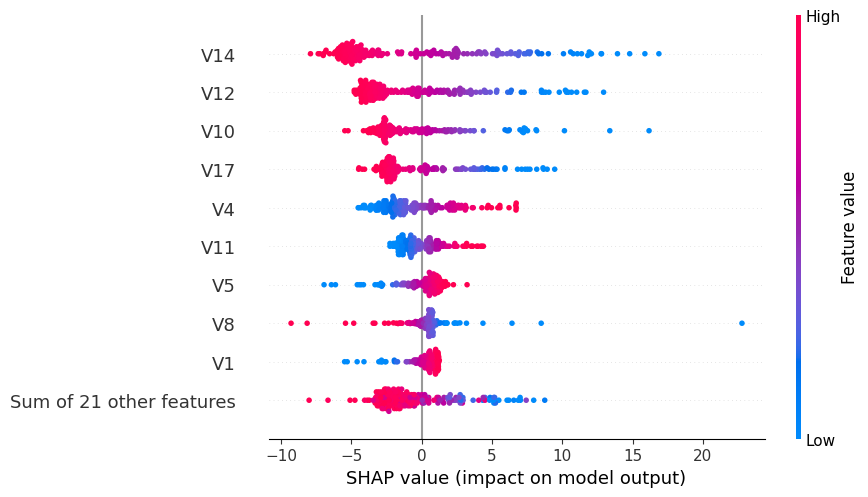

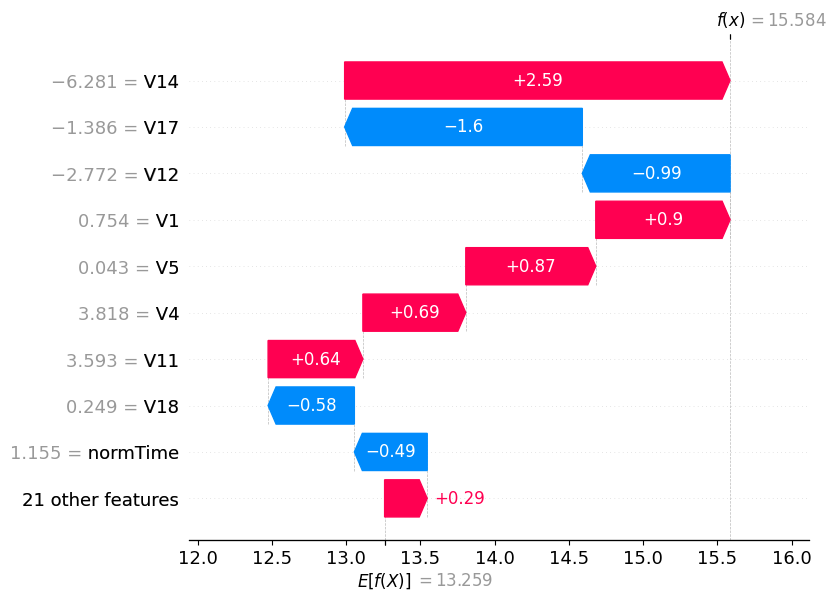

In [25]:
import shap


explainer = shap.Explainer(model, X_train)

shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)  # 全體趨勢

shap.plots.waterfall(shap_values[0])  # 單筆交易解釋

<Axes: xlabel='V14', ylabel='Density'>

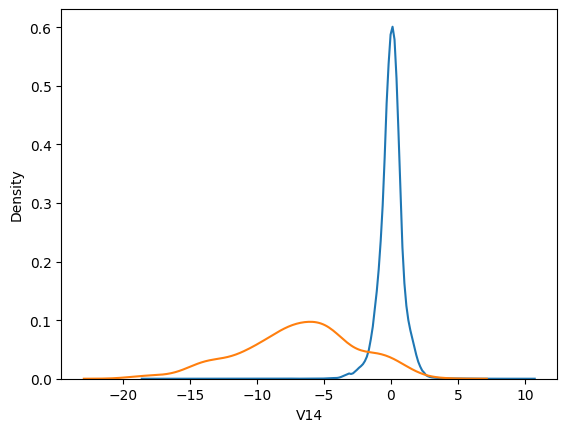

In [26]:
import seaborn as sns

sns.kdeplot(df[df["Class"] == 0]["V14"], label="Normal")
sns.kdeplot(df[df["Class"] == 1]["V14"], label="Fraud")

## 正確流程（Leakage-free）與不平衡評估補強
以下單獨新增，不修改你原有內容；以原始分布的測試集為準、避免洩漏，並加入 PR-AUC 與分層交叉驗證。


In [27]:
# 1) 從原始資料建立原始分布的 train/test（分層），避免先重採樣到測試集
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, confusion_matrix, roc_auc_score

# 以 df 為原始資料；這裡使用原始分布，不再 downsample 後再切分
X_full = df.drop('Class', axis=1)
y_full = df['Class']

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# 2) 建立 Leakage-free Pipeline：scaler 僅在訓練集 fit
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=300, class_weight='balanced', solver='lbfgs'))
])

# 訓練於原始分布的訓練集
lr_pipe.fit(X_train_lr, y_train_lr)

# 在原始分布的測試集上評估（PR-AUC 為主）
proba_test = lr_pipe.predict_proba(X_test_lr)[:, 1]
pr_auc_test = average_precision_score(y_test_lr, proba_test)
roc_auc_test = roc_auc_score(y_test_lr, proba_test)
print('Test PR-AUC (AP):', round(pr_auc_test, 5), '| ROC-AUC:', round(roc_auc_test, 5))


Test PR-AUC (AP): 0.67192 | ROC-AUC: 0.96565


In [28]:
# 3) 目標 Recall 下的閾值選擇與混淆矩陣
from sklearn.metrics import precision_recall_curve

def find_threshold_for_recall(y_true, y_prob, target_recall=0.85):
    p, r, t = precision_recall_curve(y_true, y_prob)
    idx = np.where(r[:-1] >= target_recall)[0]
    if len(idx) == 0:
        return 0.5
    return float(t[idx[-1]])

th85 = find_threshold_for_recall(y_test_lr, proba_test, target_recall=0.85)
print('Threshold for ~85% recall:', round(th85, 4))

pred85 = (proba_test >= th85).astype(int)
print(confusion_matrix(y_test_lr, pred85))
print(classification_report(y_test_lr, pred85, digits=4, zero_division=0))


Threshold for ~85% recall: 0.7955
[[56220   431]
 [   14    81]]
              precision    recall  f1-score   support

           0     0.9998    0.9924    0.9961     56651
           1     0.1582    0.8526    0.2669        95

    accuracy                         0.9922     56746
   macro avg     0.5790    0.9225    0.6315     56746
weighted avg     0.9983    0.9922    0.9948     56746



In [29]:
# 4) 5-fold 分層交叉驗證：OOF PR-AUC（更穩健）
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_oof_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=300, class_weight='balanced', solver='lbfgs'))
])

# cross_val_predict 會在每折上以「未看過該折」的模型產生機率，避免洩漏
proba_oof = cross_val_predict(lr_oof_pipe, X_full, y_full, cv=cv, method='predict_proba')[:, 1]
print('OOF PR-AUC (5-fold stratified):', round(average_precision_score(y_full, proba_oof), 5))


OOF PR-AUC (5-fold stratified): 0.71096


### 修正與結果說明
- 避免洩漏：使用 Pipeline 讓標準化僅在訓練集 fit；測試集只做 transform。
- 評估分布正確：測試集維持原始不平衡分布；不使用下採樣到測試集。
- 主指標：加入 PR-AUC（AP）與 PR 曲線思維；ROC-AUC 仍可當輔助。
- 閾值策略：依目標 Recall 選擇 threshold，回報對應混淆矩陣與告警量。
- 穩健性：以 5-fold Stratified OOF 機率計算 OOF PR-AUC，避免單次切分偶然性。

請以 Test PR-AUC 與 OOF PR-AUC 為排序能力主依據；實務部署以目標 Recall 下的混淆矩陣與告警量做決策，再視需要加入機率校準與成本最佳化閾值（可參考 `AlternativeMethods.ipynb` 的做法）。
